In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import models, layers, regularizers
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,ConfusionMatrixDisplay
import cv2
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score
from collections import Counter

In [2]:
train_path = './chest_xray/train'
test_path = './chest_xray/test'
val_path = './chest_xray/val'

In [3]:
def plot_images(img_dir, top=10):
    all_img_dirs = os.listdir(img_dir)
    img_files = [os.path.join(img_dir, file) for file in all_img_dirs][:5]
    plt.figure(figsize=(10, 10))
    plt.suptitle(img_dir.split("/")[-1])
    for idx, img_path in enumerate(img_files):
        plt.subplot(5, 5, idx + 1)
        img = plt.imread(img_path)
        plt.tight_layout()
        plt.axis('off')
        plt.imshow(img, cmap='gray')

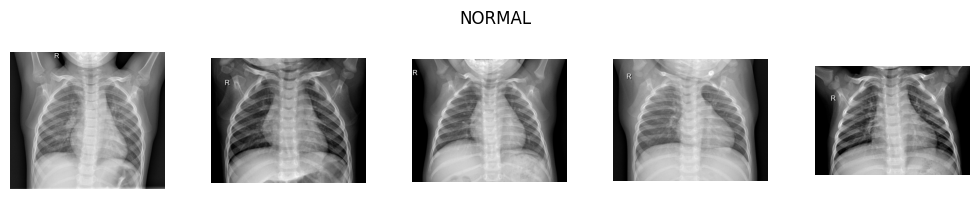

In [4]:
plot_images(train_path + '/NORMAL')

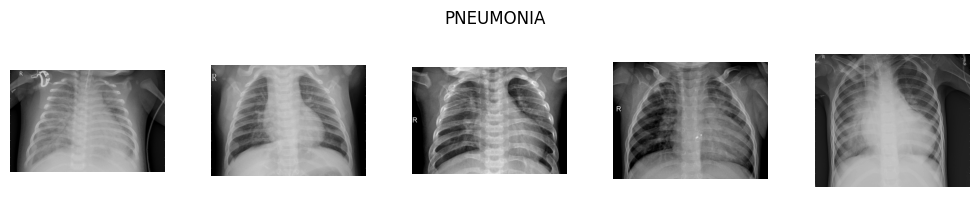

In [5]:
plot_images(train_path + '/PNEUMONIA')

In [6]:
def plot_bar_chart_diagram(path_data):
    dic = {}
    for file in os.listdir(path_data):
        if file == ".DS_Store":
            continue
        dem = 0
        for x in os.listdir(path_data + "/" + file):
            dem += 1
        dic[file] = dem
    print(dic)
    barlist = plt.bar(list(range(len(dic))),
                      list(dic.values()),
                      tick_label=list(dic.keys()))
    plt.show()

{'NORMAL': 1341, 'PNEUMONIA': 3875}


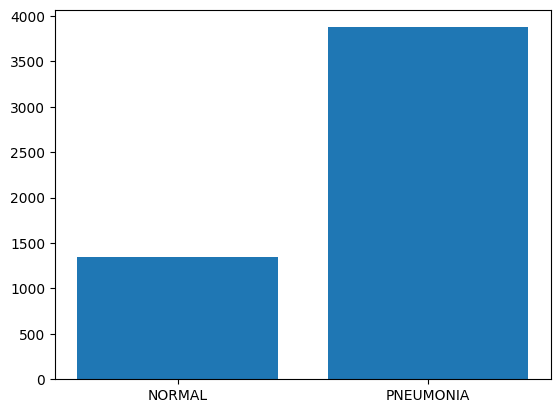

In [7]:
plot_bar_chart_diagram(train_path)

{'NORMAL': 234, 'PNEUMONIA': 390}


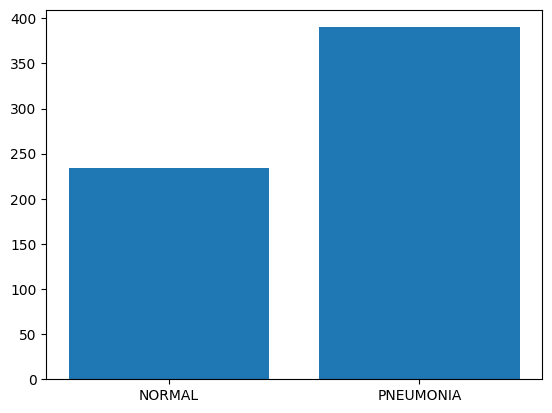

In [8]:
plot_bar_chart_diagram(test_path)

In [10]:
batch_size = 32
target_size = (116,82)

train_datagen = ImageDataGenerator(rescale=1./255.0,
                                   validation_split=0.3,
                                   zoom_range=0.8,
                                  horizontal_flip=True,
                
                                  )
test_datagen=ImageDataGenerator(rescale = 1./255.0)

train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=target_size,
        batch_size=batch_size,
        subset="training",
        class_mode='binary')

val_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=target_size,
        batch_size=batch_size,
        subset="validation",
        class_mode='binary')
test_generator=test_datagen.flow_from_directory(
        test_path,
        target_size=target_size,
        class_mode='binary',
        batch_size=batch_size,
        shuffle=False)

Found 3652 images belonging to 2 classes.
Found 1564 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [11]:
input_shape = (116,82,3)

In [12]:
model = models.Sequential()

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())

model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 114, 80, 64)       1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 114, 80, 64)       36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 57, 40, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 57, 40, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 57, 40, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 57, 40, 128)       147584    
                                                      

In [13]:
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam( lr=0.0001), metrics=['accuracy'],) 

In [16]:
earlystop =tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=15, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.5, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)

weight_for_0 = (1.0 / 1341)*(5216/2.0)
weight_for_1 = (1.0 / 3875)*(5216/2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}
callback=[earlystop,reduce_lr]
history = model.fit(train_generator, epochs=1 ,verbose=1, validation_data=val_generator,callbacks=callback,class_weight=class_weight,)

115/115 [==============================] - 894s 8s/step - loss: 0.6941 - accuracy: 0.5871 - val_loss: 0.6905 - val_accuracy: 0.7430 - lr: 0.0010


In [17]:
score = model.evaluate(val_generator) 
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

49/49 [==============================] - 72s 1s/step - loss: 0.6905 - accuracy: 0.7430
Test loss:  0.6905496716499329
Test accuracy:  0.7429667711257935


In [18]:
score = model.evaluate(test_generator) 
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

20/20 [==============================] - 38s 2s/step - loss: 0.6918 - accuracy: 0.6250
Test loss:  0.6918177008628845
Test accuracy:  0.625


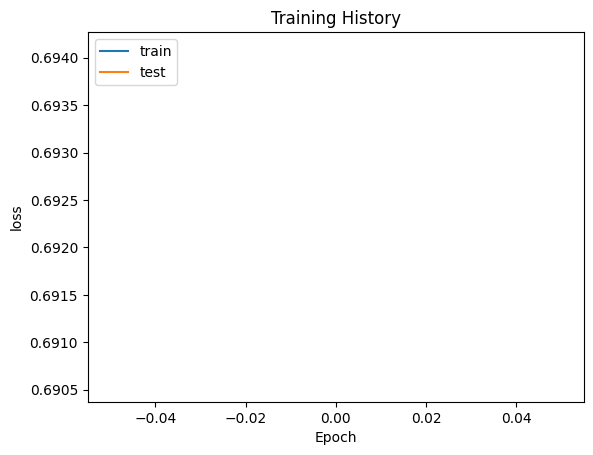

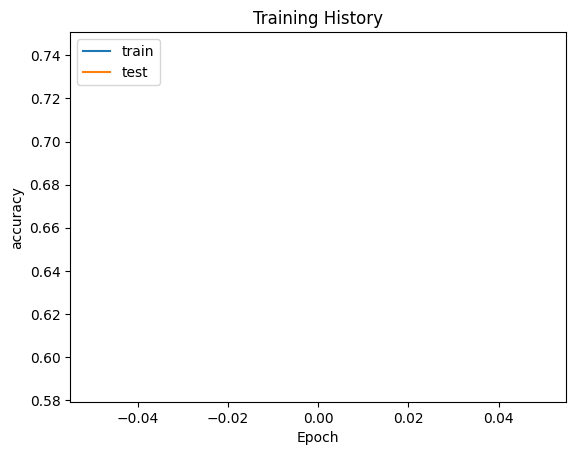

In [19]:
keys=history.history.keys()

def show_train_history(hisData,train,test): 
    plt.plot(hisData.history[train])
    plt.plot(hisData.history[test])
    plt.title('Training History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

show_train_history(history, 'loss', 'val_loss')
show_train_history(history, 'accuracy', 'val_accuracy')

20/20 [==============================] - 29s 1s/step


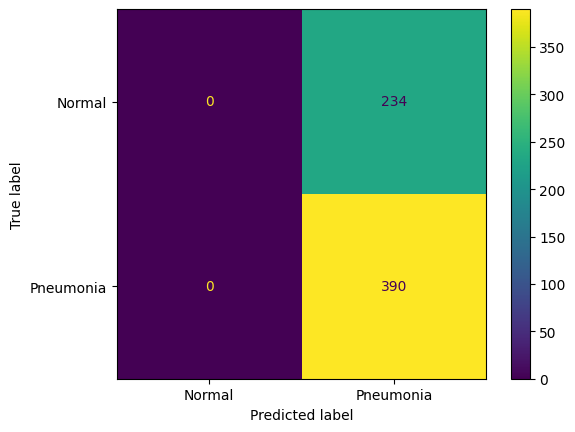

In [20]:
y_pred = np.round(model.predict(test_generator))
y_true = test_generator.classes
y_labels = list(test_generator.class_indices.keys())
display(ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=['Normal', 'Pneumonia']).plot())